In [662]:
from sklearn import datasets
import pandas as pd
import numpy as np
import time
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow import keras

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings('ignore')

In [734]:
X_train = pd.read_csv('Data/X_train.csv', index_col='building_id')
X_test = pd.read_csv('Data/X_test.csv', index_col='building_id')
y_train = pd.read_csv('Data/y_train.csv', index_col='building_id')
y_test = pd.read_csv('Data/y_test.csv', index_col='building_id')

In [735]:
X_pure_train, X_val, y_pure_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=.2)

In [736]:
binary_cols = []
for col in X_train.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(X_train.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [737]:
binary_cols_dropped = binary_cols.copy()
for col in binary_cols_dropped:
    if col.startswith('has_secondary'):
        binary_cols_dropped.remove(col)
binary_cols_dropped.append('has_secondary_use')

cat_cols_dropped = cat_cols.copy()
cat_cols_dropped.remove('legal_ownership_status')
cat_cols_dropped.remove('plan_configuration')

In [738]:
def log_transform(x):
    return np.log(x+1)

In [739]:
function_transformer = FunctionTransformer(log_transform)

ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
integer_pipe = imbPipeline([
    ('function', function_transformer),
    ('ss', StandardScaler())
])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('geo', target_pipe, geo_cols),
    ('integer', integer_pipe, integer_cols),
])

In [740]:
X_pure_train = transformer.fit_transform(X_pure_train, y_pure_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

In [741]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.values)
y_val = ohe.transform(y_val.values)

In [742]:
keras0 = Sequential()
keras0.add(Dense(256, input_dim=49, activation='relu'))
keras0.add(Dense(256, activation='relu'))
keras0.add(Dense(128, activation='relu'))
keras0.add(Dense(64, activation='relu'))
keras0.add(Dense(32, activation='relu'))
keras0.add(Dense(16, activation='relu'))
keras0.add(Dense(8, activation='relu'))
keras0.add(Dense(8, activation='relu'))
keras0.add(Dense(8, activation='relu'))
keras0.add(Dense(8, activation='relu'))
keras0.add(Dense(3, activation='softmax'))

keras0.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [743]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

In [744]:
results = keras0.fit(X_pure_train, y_pure_train, epochs=50, batch_size=1000, 
                     validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50
157/157 [==============================] - 2s 10ms/step - loss: 0.9851 - categorical_accuracy: 0.5659 - val_loss: 0.6945 - val_categorical_accuracy: 0.7021
Epoch 2/50
157/157 [==============================] - 1s 9ms/step - loss: 0.5961 - categorical_accuracy: 0.7359 - val_loss: 0.6237 - val_categorical_accuracy: 0.7278
Epoch 3/50
157/157 [==============================] - 1s 9ms/step - loss: 0.5772 - categorical_accuracy: 0.7450 - val_loss: 0.6170 - val_categorical_accuracy: 0.7287
Epoch 4/50
157/157 [==============================] - 1s 9ms/step - loss: 0.5710 - categorical_accuracy: 0.7468 - val_loss: 0.6176 - val_categorical_accuracy: 0.7305
Epoch 5/50
157/157 [==============================] - 2s 10ms/step - loss: 0.5690 - categorical_accuracy: 0.7474 - val_loss: 0.6163 - val_categorical_accuracy: 0.7285
Epoch 6/50
157/157 [==============================] - 2s 10ms/step - loss: 0.5657 - categorical_accuracy: 0.7484 - val_loss: 0.6199 - val_categorical_accuracy: 0.7277
E

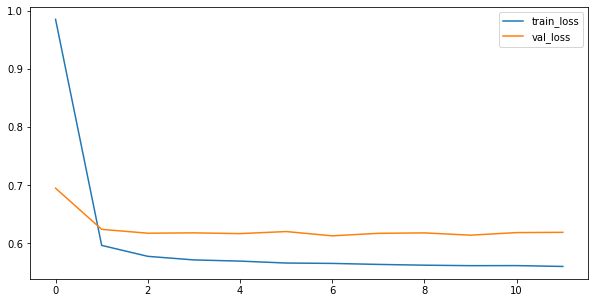

In [745]:
train_loss = results.history['loss']
val_loss = results.history['val_loss']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax, label='train_loss')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax, label='val_loss');

In [748]:
keras0.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_241 (Dense)            (None, 256)               12800     
_________________________________________________________________
dense_242 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_243 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_244 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_245 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_246 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_247 (Dense)            (None, 8)               

In [746]:
y_hat_test = np.argmax(keras0.predict(X_test), axis=-1)

In [747]:
f1_score(y_test, y_hat_test + 1, average='micro')

0.7300578655738209

### Reshape y_train for the Keras model

I need y_train in the shape (len(y_train), 3).  I also need to re-encode y so that 1, 2, 3 goes to 0, 1, 2, so that I can use np.utils.to_categorical.  When I do my predictions, I will reverse this encoding with np.argmax.

In [515]:
y_train_adj = y_train - 1

In [516]:
dummy_y_train = np_utils.to_categorical(y_train_adj)

In [517]:
dummy_y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

### Column Transformer

I will be doing the ususal transformations:  dropping unimportant columns, log-transforming and scaling the integer columns, and target encoding the categorical columns.

In [518]:
binary_cols = []
for col in X_train.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(X_train.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [519]:
binary_cols_dropped = binary_cols.copy()
for col in binary_cols_dropped:
    if col.startswith('has_secondary'):
        binary_cols_dropped.remove(col)
binary_cols_dropped.append('has_secondary_use')

cat_cols_dropped = cat_cols.copy()
cat_cols_dropped.remove('legal_ownership_status')
cat_cols_dropped.remove('plan_configuration')

In [520]:
def log_transform(x):
    return np.log(x+1)

In [521]:
function_transformer = FunctionTransformer(log_transform)

ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
integer_pipe = imbPipeline([
    ('function', function_transformer),
    ('ss', StandardScaler())
])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('geo', target_pipe, geo_cols),
    ('integer', integer_pipe, integer_cols),
])

In [522]:
transformed_X_train = transformer.fit_transform(X_train, y_train)

In [523]:
transformed_X_train.shape

(195450, 49)

The final X_train has 49 features.

### Pickle the Column Transformer

In [524]:
with open ('../Models/keras_transformer.pickle', 'wb') as f:
    pickle.dump(transformer, f, pickle.HIGHEST_PROTOCOL)

### keras0:  Build a simple neural network

In [525]:
keras0 = Sequential()
keras0.add(Dense(8, input_dim=49, activation='relu'))
keras0.add(Dense(3, activation='softmax'))

keras0.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [526]:
start = time.time()
keras0.fit(transformed_X_train, dummy_y_train, epochs=1, batch_size=1000)
end = time.time()
print(f'Runtime: {end-start} seconds')

196/196 [==============================] - 0s 1ms/step - loss: 0.9841 - categorical_accuracy: 0.5068
Runtime: 0.6388249397277832 seconds


### Create a cross validation procedure

In [527]:
def custom_cross_val(model, X=transformed_X_train, y=dummy_y_train, epochs=1,\
                     batch_size=1000, n_splits=5, shuffle=True):
    
    """Takes in a model and performs a cross-validation and returns the average micro-averaged F1 score.
    
    Parameters
    ------------
    model: the name of the model
    X:  default is 'transformed_X_train'
    y:  default is 'dummy_y_train
    epochs: default is 1
    batch_size: default is 1000
    n_splits: number of splits in the KFold, default is 5
    shuffle:  whether to shuffle the splits, default is True
    """
    
    start = time.time()
    #Create a list to hold f1-micro scores
    f1_micro_scores = []
    #Instantiate a KFold object
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=42)
    
    for train_ind, val_ind in kf.split(X):
        #Fit the model
        model.fit(X[train_ind], y[train_ind], epochs=epochs, batch_size=batch_size)
        #Make predictions
        y_pred_adj = model.predict_classes(X[val_ind])
        #Calculate the f1-micro score
        f1_micro = f1_score(np.argmax(y[val_ind], axis=1), y_pred_adj, average='micro')
        print(f1_micro)
        #Append the score to the list 
        f1_micro_scores.append(f1_micro)
    end = time.time()  
    runtime = end-start
    print('---------------------------------------------------------')
    print(f'f1-micro score: {np.mean(f1_micro_scores)},  Runtime: {runtime}')

In [528]:
custom_cross_val(keras0, epochs=10, batch_size=1000)

Epoch 1/10
157/157 [==============================] - 0s 1ms/step - loss: 0.7915 - categorical_accuracy: 0.6153
Epoch 2/10
157/157 [==============================] - 0s 1ms/step - loss: 0.7086 - categorical_accuracy: 0.6930
Epoch 3/10
157/157 [==============================] - 0s 1ms/step - loss: 0.6568 - categorical_accuracy: 0.7197
Epoch 4/10
157/157 [==============================] - 0s 1ms/step - loss: 0.6297 - categorical_accuracy: 0.7278
Epoch 5/10
157/157 [==============================] - 0s 1ms/step - loss: 0.6149 - categorical_accuracy: 0.7318
Epoch 6/10
157/157 [==============================] - 0s 1ms/step - loss: 0.6064 - categorical_accuracy: 0.7342
Epoch 7/10
157/157 [==============================] - 0s 1ms/step - loss: 0.6004 - categorical_accuracy: 0.7366
Epoch 8/10
157/157 [==============================] - 0s 1ms/step - loss: 0.5960 - categorical_accuracy: 0.7382
Epoch 9/10
157/157 [==============================] - 0s 1ms/step - loss: 0.5924 - categorical_accuracy:

### keras1:  Add more layers to the network

In [485]:
keras1 = Sequential()
keras1.add(Dense(512, input_dim=49, activation='relu'))
keras1.add(Dense(256, activation='relu'))
keras1.add(Dense(128, activation='relu'))
keras1.add(Dense(3, activation='softmax'))

keras1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[keras.metrics.CategoricalAccuracy()])

In [486]:
start = time.time()
keras1.fit(transformed_X_train, dummy_y_train, epochs=1, batch_size=1000)
end = time.time()
print(f'Runtime: {end-start} seconds')

196/196 [==============================] - 2s 11ms/step - loss: 0.6167 - categorical_accuracy: 0.7222
Runtime: 2.642557144165039 seconds


In [487]:
custom_cross_val(keras1, epochs=1, batch_size=1000)

Epoch 1/20
157/157 [==============================] - 2s 11ms/step - loss: 0.5722 - categorical_accuracy: 0.7453
Epoch 2/20
157/157 [==============================] - 2s 11ms/step - loss: 0.5670 - categorical_accuracy: 0.7470
Epoch 3/20
157/157 [==============================] - 2s 11ms/step - loss: 0.5645 - categorical_accuracy: 0.7484
Epoch 4/20
157/157 [==============================] - 2s 11ms/step - loss: 0.5613 - categorical_accuracy: 0.7492
Epoch 5/20
157/157 [==============================] - 2s 11ms/step - loss: 0.5593 - categorical_accuracy: 0.7495
Epoch 6/20
157/157 [==============================] - 2s 11ms/step - loss: 0.5564 - categorical_accuracy: 0.7506
Epoch 7/20
157/157 [==============================] - 2s 11ms/step - loss: 0.5545 - categorical_accuracy: 0.7520
Epoch 8/20
157/157 [==============================] - 2s 11ms/step - loss: 0.5549 - categorical_accuracy: 0.7515
Epoch 9/20
157/157 [==============================] - 2s 12ms/step - loss: 0.5525 - categorical_

157/157 [==============================] - 2s 12ms/step - loss: 0.4101 - categorical_accuracy: 0.8146
Epoch 13/20
157/157 [==============================] - 2s 10ms/step - loss: 0.4076 - categorical_accuracy: 0.8158
Epoch 14/20
157/157 [==============================] - 2s 11ms/step - loss: 0.4046 - categorical_accuracy: 0.8170
Epoch 15/20
157/157 [==============================] - 2s 10ms/step - loss: 0.4010 - categorical_accuracy: 0.8187
Epoch 16/20
157/157 [==============================] - 2s 10ms/step - loss: 0.3991 - categorical_accuracy: 0.8197
Epoch 17/20
157/157 [==============================] - 2s 10ms/step - loss: 0.3952 - categorical_accuracy: 0.8210
Epoch 18/20
157/157 [==============================] - 2s 11ms/step - loss: 0.3938 - categorical_accuracy: 0.8226
Epoch 19/20
157/157 [==============================] - 2s 10ms/step - loss: 0.3894 - categorical_accuracy: 0.8249
Epoch 20/20
157/157 [==============================] - 2s 10ms/step - loss: 0.3887 - categorical_acc

### keras2:  Try using SMOTE

In [531]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(transformed_X_train, y_train_adj)

In [536]:
dummy_y_train_resampled = np_utils.to_categorical(y_train_resampled)

In [550]:
keras2 = Sequential()
keras2.add(Dense(32, input_dim=49, activation='relu'))
keras2.add(Dense(16, activation='relu'))
keras2.add(Dense(8, activation='relu'))
keras2.add(Dense(3, activation='softmax'))

keras2.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [551]:
start = time.time()
keras0.fit(transformed_X_train, dummy_y_train, epochs=1, batch_size=1000)
end = time.time()
print(f'Runtime: {end-start} seconds')

196/196 [==============================] - 0s 1ms/step - loss: 0.5682 - categorical_accuracy: 0.7477
Runtime: 0.36264610290527344 seconds


In [552]:
custom_cross_val(keras2, X=X_train_resampled, y=dummy_y_train_resampled, epochs=10, batch_size=1000)

Epoch 1/10
267/267 [==============================] - 0s 1ms/step - loss: 0.8194 - categorical_accuracy: 0.5781
Epoch 2/10
267/267 [==============================] - 0s 1ms/step - loss: 0.5873 - categorical_accuracy: 0.7508
Epoch 3/10
267/267 [==============================] - 0s 1ms/step - loss: 0.5771 - categorical_accuracy: 0.7534
Epoch 4/10
267/267 [==============================] - 0s 1ms/step - loss: 0.5730 - categorical_accuracy: 0.7545
Epoch 5/10
267/267 [==============================] - 0s 1ms/step - loss: 0.5709 - categorical_accuracy: 0.7558
Epoch 6/10
267/267 [==============================] - 0s 1ms/step - loss: 0.5687 - categorical_accuracy: 0.7567
Epoch 7/10
267/267 [==============================] - 0s 1ms/step - loss: 0.5675 - categorical_accuracy: 0.7569
Epoch 8/10
267/267 [==============================] - 0s 1ms/step - loss: 0.5664 - categorical_accuracy: 0.7575
Epoch 9/10
267/267 [==============================] - 0s 1ms/step - loss: 0.5650 - categorical_accuracy:

### Transform X_test

In [412]:
transformed_X_test = transformer.transform(X_test)

### Make predictions on X_test and score the results

After predicting classes, I will reverse transform the predictions so that 0, 1, 2 is mapped to 1, 2, 3 (the original target.)

In [610]:
y_pred_adj = keras0.predict_classes(transformed_X_test)

In [611]:
y_pred = y_pred_adj + 1

In [612]:
keras_score = f1_score(y_test, y_pred, average='micro')
keras_score

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

### Export the model

In [459]:
keras0.save('../Models/keras0')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../Models/keras0/assets
